In [1]:
# work environment: jl2815
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
from skgstat import Variogram
import numpy as np
from typing import Callable   # nearest neighbor function input type
import sklearn.neighbors  # nearest neighbor
from sklearn.neighbors import BallTree # for space_center function
import sys 
#  sys.path
# !pip install numpy==2.0


from GEMS_TCO import orbitmap
# from GEMS_TCO import smoothspace
from GEMS_TCO.smoothspace import space_average

import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from matplotlib import cm  # Colormap module  # Create a colormap (e.g., 'viridis' or 'plasma')

In [2]:
df = pd.read_csv("C:\\Users\\joonw\\TCO\\data_engineering\\data_24_07_0130_N2530_E95110.csv")

resolution = 0.1 

instance = orbitmap.MakeOrbitdata(df,resolution,resolution,25,30,95,110)   # lat_s,lat_e, lon_s, lon_e
orbit_map24_7 = instance.makeorbitmap()

# instance24_7 = orbitmap.MakeOrbitdata(df,10,20,120,135)
sparse_map_24_7 = instance.make_sparsemap(orbit_map24_7,resolution)

Semivariogram 

When using N25-30, E95-110 we have 7 orbits upto first 10 days, so do:

for i in range(7*t, 7*t+7): 

After that, we can do:

for i in range(8*t, 8*t+8): 

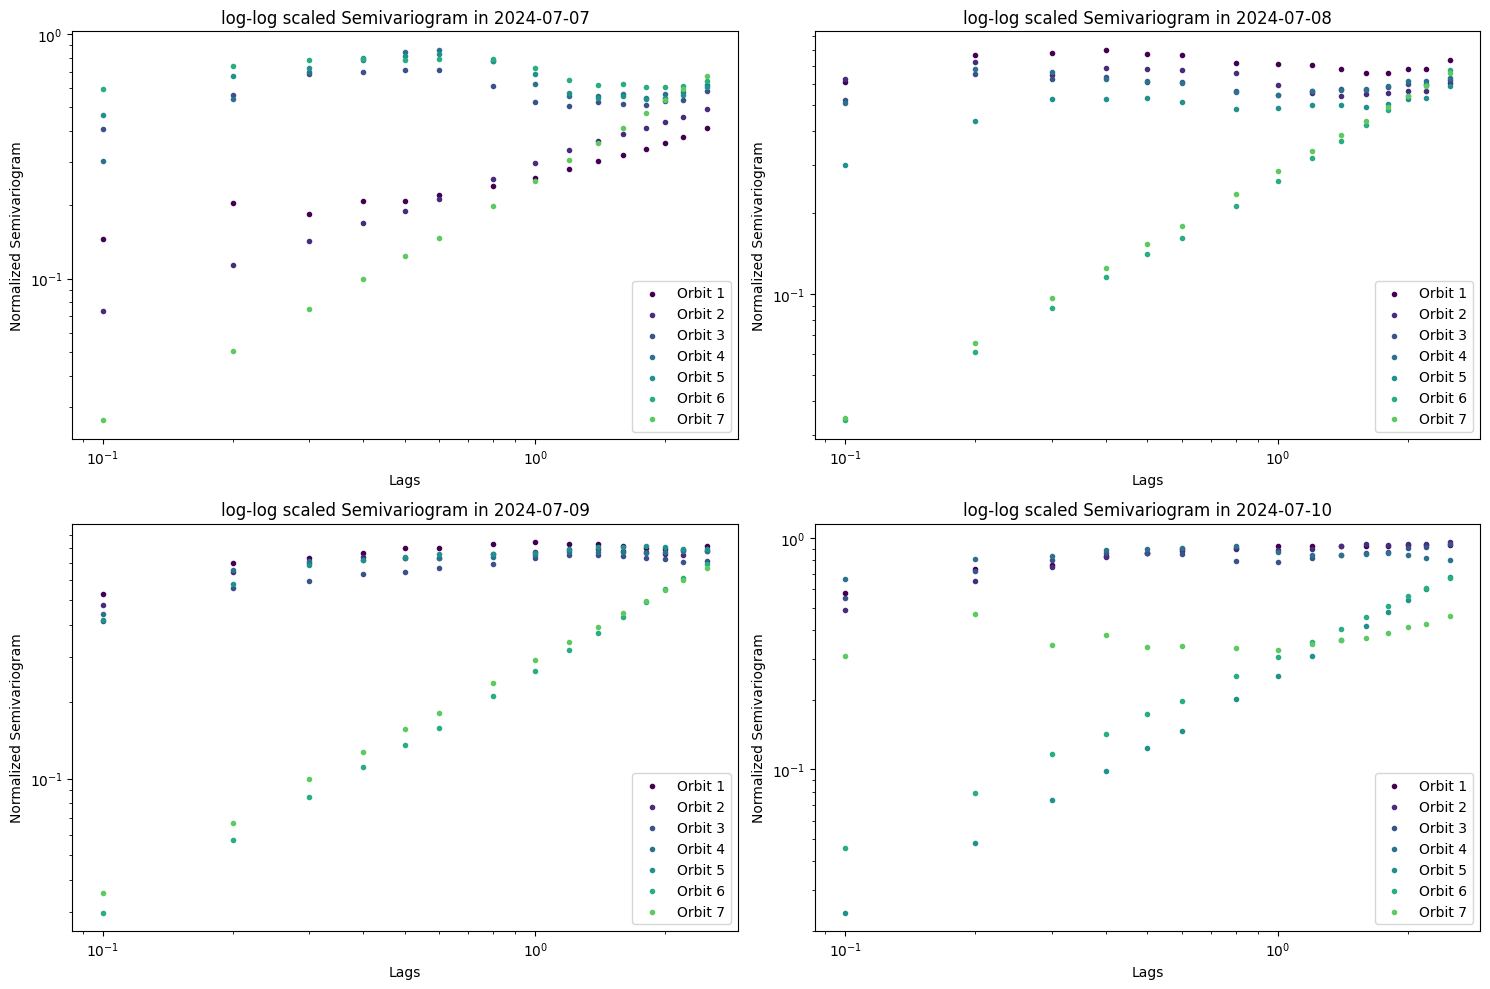

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import pdist, squareform

# Assuming `ori_semi_var_timeseries` and `lags` are defined earlier
cmap = plt.get_cmap('viridis', 9)  # Choose a colormap
days = [7, 8, 9, 10]  # Example days you want to plot
map = sparse_map_24_7
tolerance = 0.02
lags = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2, 2.2, 2.5]

# Create a 2x2 plot
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

for index, day in enumerate(days):
    t = day - 1
    ori_semi_var_timeseries = [[0] * len(lags) for _ in range(7)]
    key_list = sorted(map)

    for i in range(7 * t, 7 * t + 7):
        cur_data = map[key_list[i]]
        coordinates = np.array(cur_data[['Latitude', 'Longitude']])
        values = np.array(cur_data['ColumnAmountO3'])

        # Calculate the pairwise distances between all points
        pairwise_distances = squareform(pdist(coordinates))

        for j in range(len(lags)):
            target_distance = lags[j]
            valid_pairs = np.where((pairwise_distances >= target_distance - tolerance) &
                                   (pairwise_distances <= target_distance + tolerance))

            if len(valid_pairs[0]) == 0:
                print(f"No valid pairs found for t{j+1:02d}_{i+1} at distance {target_distance}")
                ori_semi_var_timeseries[i % 7][j] = np.nan
                continue

            # Compute the semivariance for those valid pairs
            semivariances = 0.5 * np.mean((values[valid_pairs[0]] - values[valid_pairs[1]]) ** 2)

            # Normalize the semivariance
            variance_of_data = np.var(values)
            normalized_semivariance = semivariances / variance_of_data

            # Append the normalized semivariance to the timeseries
            ori_semi_var_timeseries[i % 7][j] = normalized_semivariance

    # Plotting all orbits for the current day
    ax = axs[index // 2, index % 2]
    for i in range(7):
        color = cmap(i / 9)
        ax.scatter(lags, ori_semi_var_timeseries[i], marker='o', s=9, color=color, label=f'Orbit {i + 1}')
    ax.legend()
    ax.set_xlabel('Lags')
    ax.set_ylabel('Normalized Semivariogram')
    ax.set_title(f'log-log scaled Semivariogram in 2024-07-{day:02d}')
    ax.set_xscale('log')
    ax.set_yscale('log')

plt.tight_layout()
plt.show()


# Investigate spatial stationarity 

## West vs East

In [87]:
sparsemap24_left = {}
sparsemap24_right = {}

keys = sorted(sparse_map_24_7)

lat_s, lat_e, lon_s, lon_e = 25, 30 , 95, 110
mid = np.mean([lon_s,lon_e])

for x in keys:
    data1 = sparse_map_24_7[x]
    sparsemap24_left[x] = data1[data1['Longitude']<= mid]
    sparsemap24_right[x] = data1[data1['Longitude']> mid]

Note that
day 1 ~ day 9 contans 7 orbits and then 8 orbits per day

In [149]:
class timeseries:
    def __init__(self, map: dict):
        self.map = map

    def timeseries_var_24_7_N2530_E95110(self):
        ori_var_timeseries = []
        key_list = sorted(self.map)

        for i in range(len(key_list)):
            cur = self.map[key_list[i]]
            ori_var_timeseries.append(np.var(cur['ColumnAmountO3']))

        x_with_gaps = []
        for i in range(9):
            x_with_gaps.extend(range(i * 24, i * 24 + 7))

        x_with_gaps3 = []
        for i in range(9, 240 // 8):
            x_with_gaps3.extend(range(i * 24, i * 24 + 8))

        x_with_gaps = x_with_gaps + x_with_gaps3

        plt.figure(figsize=(12, 4))
        plt.scatter(x_with_gaps, ori_var_timeseries, marker='o', s=10, color='b')

        plt.xlabel('Orbit Indices (Red lines separate different days)', fontsize=12)
        plt.ylabel('Variance', fontsize=12)
        plt.ylim([0, 6000])
        plt.title('Variances within each orbit', fontsize=14)


        day_labels = []
        day_positions = []

        for i in range(0, 9 * 7, 7):
            plt.axvline(x=x_with_gaps[i], color='r', linestyle='--', linewidth=0.7, alpha=0.5)
            day_labels.append(f"d{i // 7 + 1}")
            day_positions.append(x_with_gaps[i])

        for i in range(63, len(ori_var_timeseries), 8):
            plt.axvline(x=x_with_gaps[i], color='r', linestyle='--', linewidth=0.7, alpha=0.5)
            day_labels.append(f"d{(i + 1) // 8 + 1}")
            day_positions.append(x_with_gaps[i])

        plt.xticks(ticks=day_positions, labels=day_labels, fontsize=10)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
        return ori_var_timeseries

    def timeseries_sem_24_7_N2530_E95110(self, target_distance, tolerance):
        ori_semi_var_timeseries = []
        key_list = sorted(self.map)
        for i in range(len(key_list)):
            cur_data = self.map[key_list[i]]
            coordinates = np.array(cur_data[['Latitude', 'Longitude']])
            values = np.array(cur_data['ColumnAmountO3'])
            pairwise_distances = squareform(pdist(coordinates))
            valid_pairs = np.where((pairwise_distances >= target_distance - tolerance) &
                                   (pairwise_distances <= target_distance + tolerance))

            if len(valid_pairs[0]) == 0:
                ori_semi_var_timeseries.append(np.nan)
                continue

            semivariances = 0.5 * np.mean((values[valid_pairs[0]] - values[valid_pairs[1]]) ** 2)
            variance_of_data = np.var(values)
            normalized_semivariance = semivariances / variance_of_data
            ori_semi_var_timeseries.append(normalized_semivariance)

        x_with_gaps = []
        for i in range(9):
            x_with_gaps.extend(range(i * 24, i * 24 + 7))

        x_with_gaps3 = []
        for i in range(9, 240 // 8):
            x_with_gaps3.extend(range(i * 24, i * 24 + 8))

        x_with_gaps = x_with_gaps + x_with_gaps3

        plt.figure(figsize=(12, 4))
        plt.scatter(x_with_gaps, ori_semi_var_timeseries, marker='o', s=10, color='b')

        plt.xlabel('Orbit Indices (Red lines separate different days)', fontsize=12)
        plt.ylabel('Semivariogram', fontsize=12)
        plt.title(f'Semivariograms within each orbit (lag {target_distance})', fontsize=14)

        day_labels = []
        day_positions = []

        for i in range(0, 9 * 7, 7):
            plt.axvline(x=x_with_gaps[i], color='r', linestyle='--', linewidth=0.7, alpha=0.5)
            day_labels.append(f"d{i // 7 + 1}")
            day_positions.append(x_with_gaps[i])

        for i in range(63, len(ori_semi_var_timeseries), 8):
            plt.axvline(x=x_with_gaps[i], color='r', linestyle='--', linewidth=0.7, alpha=0.5)
            day_labels.append(f"d{(i + 1) // 8 + 1}")
            day_positions.append(x_with_gaps[i])

        plt.xticks(ticks=day_positions, labels=day_labels, fontsize=10)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
        return ori_semi_var_timeseries


In [ ]:
instance = timeseries(sparsemap24_left)
sem1 = instance.timeseries_sem_24_7_N2530_E95110(target_distance=0.2, tolerance=0.02)
var1 = instance.timeseries_var_24_7_N2530_E95110()

instance = timeseries(sparsemap24_right)
sem2 = instance.timeseries_sem_24_7_N2530_E95110(target_distance=0.2, tolerance=0.02)
var2 = instance.timeseries_var_24_7_N2530_E95110()

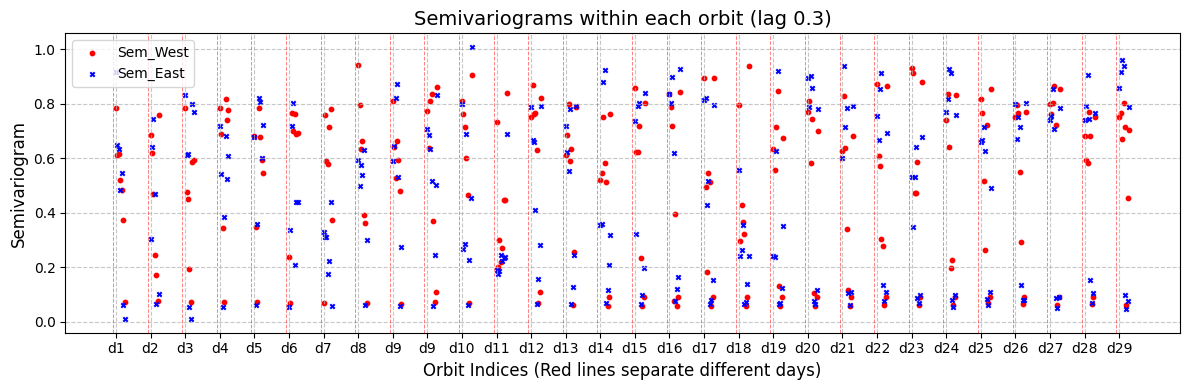

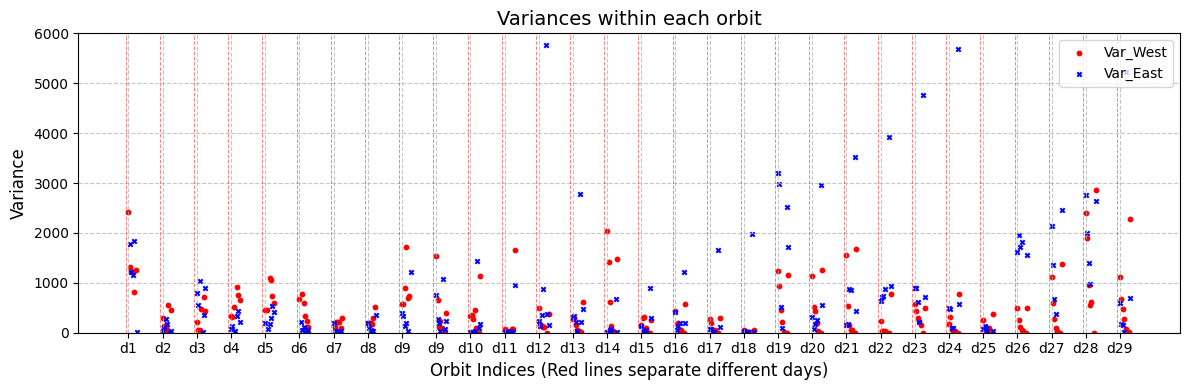

In [157]:
target_distance= 0.3

x_with_gaps = []
for i in range(9):
    x_with_gaps.extend(range(i * 24, i * 24 + 7))

x_with_gaps3 = []
for i in range(9, 240 // 8):
    x_with_gaps3.extend(range(i * 24, i * 24 + 8))

x_with_gaps = x_with_gaps + x_with_gaps3

# First plot: Semivariograms
plt.figure(figsize=(12, 4))  # Larger figure size for better clarity
plt.scatter(x_with_gaps, sem1, marker='o', s=10, color='red', label="Sem_West")  # Increased marker size
plt.scatter(x_with_gaps, sem2, marker='x', s=10, color='blue', label="Sem_East")

plt.xlabel('Orbit Indices (Red lines separate different days)', fontsize=12)  # Larger font size
plt.ylabel('Semivariogram', fontsize=12)
plt.title(f'Semivariograms within each orbit (lag {target_distance})', fontsize=14)

day_labels = []
day_positions = []

# Adding vertical lines separating days
for i in range(0, 9*7, 7):
    plt.axvline(x=x_with_gaps[i]-2, color='r', linestyle='--', linewidth=0.7, alpha=0.5)
    day_labels.append(f"d{i // 7 + 1}")
    day_positions.append(x_with_gaps[i])

for i in range(63, len(sem1), 8):
    plt.axvline(x=x_with_gaps[i]-2, color='r', linestyle='--', linewidth=0.7, alpha=0.5)
    day_labels.append(f"d{(i + 1) // 8 + 1}")
    day_positions.append(x_with_gaps[i])

plt.xticks(ticks=day_positions, labels=day_labels, fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()  # Adjust the layout
plt.show()

# Second plot: Variances
plt.figure(figsize=(12, 4))  # Same figure size as above
plt.scatter(x_with_gaps, var1, marker='o', s=10, color='red', label="Var_West")  # Increased marker size
plt.scatter(x_with_gaps, var2, marker='x', s=10, color='blue', label="Var_East")

plt.xlabel('Orbit Indices (Red lines separate different days)', fontsize=12)
plt.ylabel('Variance', fontsize=12)
plt.ylim([0, 6000])
plt.title('Variances within each orbit', fontsize=14)

day_labels = []
day_positions = []

# Adding vertical lines separating days
for i in range(0, 9*7, 7):
    plt.axvline(x=x_with_gaps[i]-2, color='r', linestyle='--', linewidth=0.7, alpha=0.5)
    day_labels.append(f"d{i // 7 + 1}")
    day_positions.append(x_with_gaps[i])

for i in range(63, len(var1), 8):
    plt.axvline(x=x_with_gaps[i]-2, color='r', linestyle='--', linewidth=0.7, alpha=0.5)
    day_labels.append(f"d{(i + 1) // 8 + 1}")
    day_positions.append(x_with_gaps[i])

plt.xticks(ticks=day_positions, labels=day_labels, fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


Why variances are so high? let's look at Ozone values

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_27836\2643761461.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


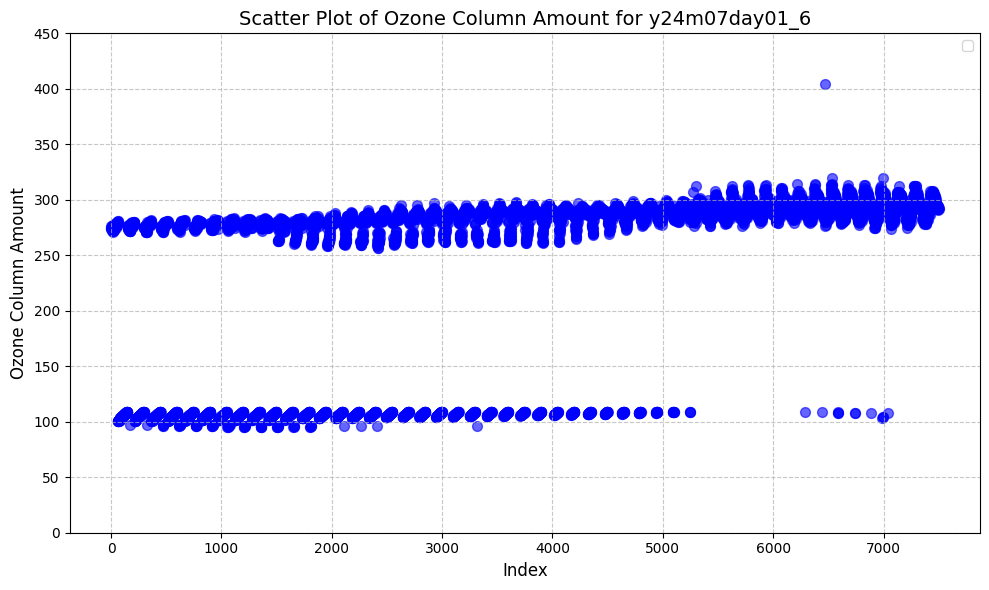

In [151]:
map = sparse_map_24_7

ori_var_timeseries = []
key_list = sorted(map)

# Calculate variance for each orbit and print where values exceed 400
for i in range(len(key_list)):
    cur = map[key_list[i]]
    ori_var_timeseries.append(np.var(cur['ColumnAmountO3']))
    # print(f'orbit {i} : {np.where(cur['ColumnAmountO3']>400)}')
    # print(f'orbit {i} : {np.var(cur['ColumnAmountO3'])}')

# For a specific orbit 'y24m07day01_6', plot its ozone column amount
a = sparse_map_24_7['y24m07day01_6']['ColumnAmountO3']

# Scatter plot with improvements
plt.figure(figsize=(10, 6))
plt.scatter(a.index, a, marker='o', s=50, alpha=0.6, color='blue')  # Larger marker size and transparency

# Highlight outliers (values > 400)
# outliers = a[a > 400]
#if not outliers.empty:
#    plt.scatter(outliers.index, outliers, color='red', s=60, label='Outliers (> 400)', zorder=5)

# Adding labels and title
plt.xlabel('Index', fontsize=12)
plt.ylabel('Ozone Column Amount', fontsize=12)
plt.title('Scatter Plot of Ozone Column Amount for y24m07day01_6', fontsize=14)

# Adding gridlines
plt.grid(True, linestyle='--', alpha=0.7)

# Optional: Adjust y-axis to focus on main value range
plt.ylim([0, 450])

# Display the plot
plt.tight_layout()
plt.legend()
plt.show()


It appears that the ozone data forms two distinct clusters. One cluster is concentrated around values near 100, and a larger concentration of values is observed in the range between 270 and 300. 

Possibly indicate different atmospheric conditions. 

# Space and Time interaction

### Cross periodogram:

Examine how spatial pattern of $X_1$ at time t-1 is related to that of $X_2$ at time t in terms of spatial frequency. 

$$
I_{xy} = \frac{1}{N} (\sum_x Z_1(x) e^{-i\omega x}) (\sum_y Z_2(y)e^{i \omega y} )
$$

The cross periodogram shows at which frequencies two processes have strong correlations. This is useful for data with periodic components.

Cross-variogram does something similar, but it measures correlation over distances. It shows how correlation decreases as distance increases. 

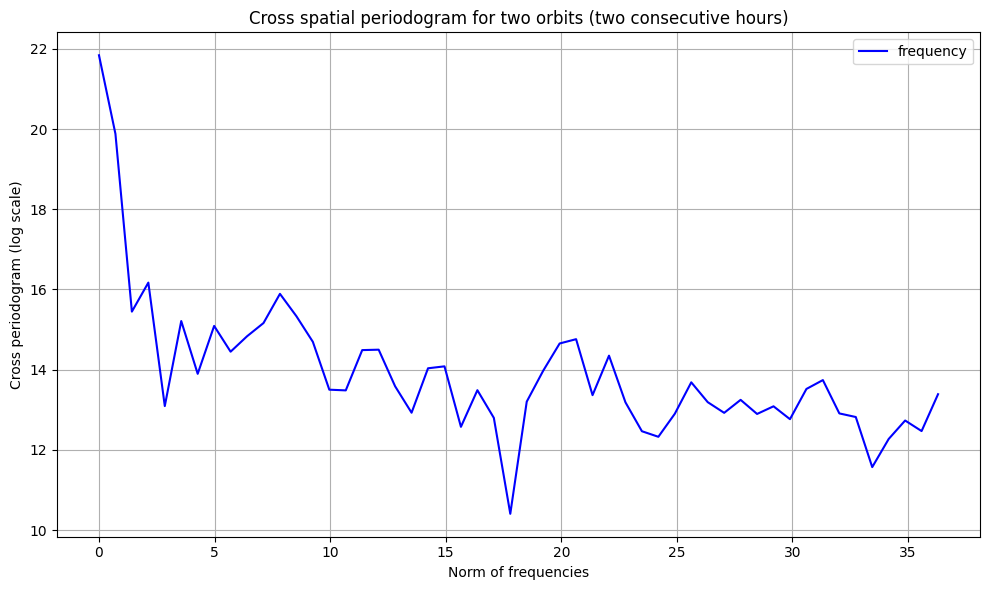

In [156]:
data1 = sparse_map_24_7['y24m07day01_1']
data2 = sparse_map_24_7['y24m07day01_2']

# Merge data directly on Latitude and Longitude
merged_df = pd.merge(data1,data2, on=['Latitude', 'Longitude'], suffixes=('_t1', '_t2'))

# Extracting ozone data and coordinates
test_df = pd.DataFrame({'s1': merged_df['ColumnAmountO3_t1'], 's2': merged_df['ColumnAmountO3_t2']})
tmp_x = merged_df[['Latitude', 'Longitude']]
tmp_y = merged_df[['Latitude', 'Longitude']]

# Spatial frequency array
x = np.array(list(range(52))) / (np.pi)

# Initialize result array for storing the cross-periodogram results
res = [0] * 52

# Calculate cross periodogram for each frequency
for i in range(52):  
    freq = [2 * x[i], x[i]]  # Frequency vector for each iteration
    tmp = np.exp(-1j * np.dot(tmp_x, freq))  # Fourier transform on spatial data for orbit at t-1
    tmp2 = np.exp(1j * np.dot(tmp_y, freq))  # Fourier transform conjugate for orbit at t
    
    # Multiply by the corresponding column amount of ozone data
    tmp_xx = np.array(merged_df['ColumnAmountO3_t1']) * tmp
    tmp_yy = np.array(merged_df['ColumnAmountO3_t2']) * tmp2
    
    # Compute cross periodogram as the product of sums of transformed data, normalized by the number of points
    res[i] = sum(tmp_xx) * sum(tmp_yy) / len(tmp_xx)

# Convert the result to real numbers and normalize by spatial frequency
norms = np.sqrt(x**2 + (2 * x)**2)

# Plot the result (Cross periodogram)
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(norms, np.log(np.abs(res)), label='frequency', color='blue')  # Take the log of the magnitude
plt.xlabel('Norm of frequencies')
plt.ylabel('Cross periodogram (log scale)')
plt.title('Cross spatial periodogram for two orbits (two consecutive hours)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



A large cross periodogram value at certain frequency implies a strong correlation at that frequency.

It appears there is a significant interaction in space and time, particularly at low spatial frequencies. This means that large-scale patterns of ozone values are relatively stable, while smaller-scale variations are less consistent.

Now lets look at time series of empirical cross-variogram at lag 0.1

In [184]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform

cross_variograms = []
target_distance = 0.1  # Specific distance of interest
tolerance = 0.02
keys = sorted(sparse_map_24_7)

for day in range(1, 10):
    for i in range(6):
        cur_data = sparse_map_24_7[keys[(day-1)*7+i]]
        next_data = sparse_map_24_7[keys[(day-1)*7+i + 1]]

        coordinates = np.array(cur_data[['Latitude', 'Longitude']])
        values = np.array(cur_data['ColumnAmountO3'])
        values2 = np.array(next_data['ColumnAmountO3'])

        # Calculate the pairwise distances between all points
        pairwise_distances = squareform(pdist(coordinates))

        # Calculate the semivariance for pairs with distances near the target distance
        valid_pairs = np.where((pairwise_distances >= target_distance - tolerance) &
                               (pairwise_distances <= target_distance + tolerance))

        if len(valid_pairs[0]) == 0:
            print(f"No valid pairs found for day {day}, orbit {i} at distance {target_distance}")
            cross_variograms.append(np.nan)
            continue

        # Compute the cross-variogram for those valid pairs
        cross_variogram = 0.5 * np.mean((values[valid_pairs[0]] - values[valid_pairs[1]] - 
                                         (values2[valid_pairs[0]] - values2[valid_pairs[1]]))**2)

        # Append the cross-variogram to the list
        cross_variograms.append(cross_variogram)

for day in range(10, 31):
    for i in range(7):
        cur_data = sparse_map_24_7[keys[63 + (day-10)*8 +i]]
        next_data = sparse_map_24_7[keys[63 + (day-10)*8 +i + 1]]

        coordinates = np.array(cur_data[['Latitude', 'Longitude']])
        values = np.array(cur_data['ColumnAmountO3'])
        values2 = np.array(next_data['ColumnAmountO3'])

        # Calculate the pairwise distances between all points
        pairwise_distances = squareform(pdist(coordinates))

        # Calculate the semivariance for pairs with distances near the target distance
        valid_pairs = np.where((pairwise_distances >= target_distance - tolerance) &
                               (pairwise_distances <= target_distance + tolerance))

        if len(valid_pairs[0]) == 0:
            print(f"No valid pairs found for day {day}, orbit {i} at distance {target_distance}")
            cross_variograms.append(np.nan)
            continue

        # Compute the cross-variogram for those valid pairs
        cross_variogram = 0.5 * np.mean((values[valid_pairs[0]] - values[valid_pairs[1]] - 
                                         (values2[valid_pairs[0]] - values2[valid_pairs[1]]))**2)

        # Append the cross-variogram to the list
        cross_variograms.append(cross_variogram)

cross_variograms = pd.Series(cross_variograms)


In [183]:
len(cross_variograms)

194

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_27836\1171125778.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


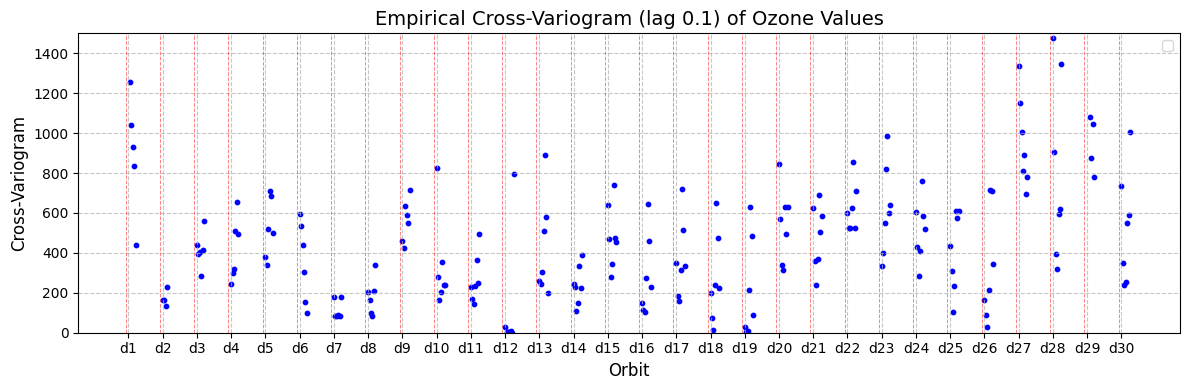

In [193]:
x_with_gaps = []
for i in range(9):
    x_with_gaps.extend(range(i * 24, i * 24 + 6))

x_with_gaps3 = []
for i in range(9, 240 // 8):
    x_with_gaps3.extend(range(i * 24, i * 24 + 7))

x_with_gaps = x_with_gaps + x_with_gaps3

# Scaling the plot
plt.figure(figsize=(12, 4))

# Scatter plot with increased marker size and blue color
plt.scatter(x_with_gaps, cross_variograms, marker='o', s=10, color='blue')

# Set limits for the y-axis (you can adjust this based on the range of your data)
plt.ylim(0, 1500)

# Adding labels and title
plt.xlabel('Orbit', fontsize=12)
plt.ylabel('Cross-Variogram', fontsize=12)
plt.title('Empirical Cross-Variogram (lag 0.1) of Ozone Values', fontsize=14)

day_labels = []
day_positions = []

# Adding vertical lines separating days
for i in range(0, 9*6, 6):
    plt.axvline(x=x_with_gaps[i]-2, color='r', linestyle='--', linewidth=0.7, alpha=0.5)
    day_labels.append(f"d{i // 6 + 1}")
    day_positions.append(x_with_gaps[i])

for i in range(54, len(cross_variograms), 7):
    plt.axvline(x=x_with_gaps[i]-2, color='r', linestyle='--', linewidth=0.7, alpha=0.5)
    day_labels.append(f"d{(i + 1) // 7 + 1 + 2}")
    day_positions.append(x_with_gaps[i])

plt.xticks(ticks=day_positions, labels=day_labels, fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()  # Adjust the layout
plt.show()

High cross-variogram values indicate larger spatial differences in ozone concentrations between two consecutive orbits, suggesting more variability or change in the atmospheric conditions.

Low cross-variogram values suggest spatial stability, where the spatial pattern of ozone values remains relatively unchanged between consecutive orbits.

The fluctuations between high and low values across different days indicate that the degree of spatial change in ozone is not constant but varies over time, potentially due to dynamic atmospheric processes.